# Building a support chatbot in LangGraph

## Setup

In [3]:
%%capture --no-stderr
%pip install -U langgraph langsmith

In [1]:
import getpass
import os 

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

## 1. Build a basic chatbot

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Type of messages: list
    # `add_messages`: how this state key should be updated
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

1. Node
    - INPUT: the current State
    - OUTPUT: a value that updates the state
2. messages
    - appended to the current list
    - communicated via `add_messages` in `Annotated`

In [5]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1")

def chatbot(state: State):
    return{"messages": [llm.invoke(state["messages"])]}

# 1st arg: unique node name
# 2nd arg: function or object called whenever the node's used
graph_builder.add_node("chatbot", chatbot)

`entry`: Where to start its work

In [6]:
graph_builder.add_edge(START, "chatbot")

`finish`: any time this node is run, you can exit

In [7]:
graph_builder.add_edge("chatbot", END)

`CompiledGraph`: we can use invoke on our state

In [8]:
graph = graph_builder.compile()

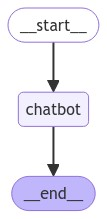

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # (Optional) extra dependecies
    pass

In [11]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: I couldn't find any information on "langgraph." It's possible that it's a misspelling, a made-up word, or something very niche.

However, I can think of a few possibilities:

1. **Language graph**: This could be a concept in linguistics or computer science related to visualizing language data, such as the structure and relationships between words, concepts, or entities.
2. **LanguagE Graph**: A more plausible interpretation is that langgraph is an abbreviation for "language engineering graph," which might refer to a framework or tool for representing and analyzing linguistic information in a graphical format.

If none of these possibilities resonate with you, could you please provide more context about where you heard of langgraph? I'd be happy to try and help clarify what it's all about!
Assistant: It seems that you forgot to ask a question or provide any context for our conversation. I'd be happy to chat with you, but I need something to respond to.

If you're ready, we ca

## 2. Enhencing the Chatbot with Tools

In [2]:
_set_env("TAVILY_API_KEY")

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the graph .'}]

**The same as in Part 1**

In [10]:
from typing import Annotated

from langchain_ollama import ChatOllama
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    message: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOllama(model="llama3.1")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

`BasicToolNode`
- checkts the most recent message in the state and calls tools if the message contains `tool_calls`.
- relies on the LLM's `tool_calling` support


In [11]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

`route_tools`: checks for tool_calls in the chatbot's output.
`add_conditional_edges`: tells the graph that whenever the `chatbot` ndoe completes to check this function.

In [12]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the 'chatbot' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

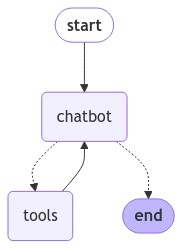

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

InvalidUpdateError: Must write to at least one of ['message']